## Author: Graham Hay


## Credit Default Classification

In this notebook, we explore a data set containing bank loan records, labelled as either a good loan that was repaid or a bad loan where the customer defaulted. The data set was obtained from the Open ML web site at https://www.openml.org/d/31, but originally came from the UCI repository (Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science).

The data set contains 1000 labelled examples with 20 features, of which 700 are good loans and 300 are bad loans. So the data set is imbalanced but not extremely so. 

The task is to learn a binary classifier that will predict if a loan to an applicant will be good or bad. 




In [1]:
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from pandas import DataFrame
    import seaborn as sns
    from PreProcessing import preprocess_data, make_scale_transformer

    INPUT_FILE = 'dataset_31_credit-g.csv'
    PERCENTILE_LOWER = 0.025
    PERCENTILE_UPPER = 0.975
    CONF_998_2TAIL = 3.08


In [2]:
    # inline only needed in older versions of Jupyter
    %matplotlib inline
    # Increase the size of the plots from the default (72)
    plt.rcParams['figure.dpi'] = 100

### Load and describe the data

Here we use the Pandas library.

In [3]:
    df = pd.read_csv(INPUT_FILE)
    print(INPUT_FILE)
    print('Shape:', df.shape)
    # print(df.memory_usage(deep=True))

    # Class distribution
    print("\nClass Distribution\n")
    print(df.groupby('class').size())

    # Description of each field
    for column_name, column_data in df.iteritems():
        print('\nField: {}'.format(column_name))
        if column_data.dtype in [np.int64, np.float64]:
            print(column_data.describe())
            # Check values outside percentile range
            lower = column_data.quantile(0.05)
            upper = column_data.quantile(0.95)
            print('Count of values outside 5th and 95th percentile ({}, {})'.
                  format((column_data[column_data < lower].count()), column_data[column_data > upper].count()))
            # Check Z-scores outside confidence range
            mu = column_data.mean()
            sd = column_data.std()
            print('Count of values with Z-scores outside 99.8% confidence ({}, {})'.
                  format(column_data[column_data < (mu - CONF_998_2TAIL*sd)].count(),
                         column_data[column_data > (mu + CONF_998_2TAIL*sd)].count()))
        else:
            print(pd.value_counts(column_data))


dataset_31_credit-g.csv
Shape: (1000, 21)

Class Distribution

class
bad     300
good    700
dtype: int64

Field: checking_status
'no checking'    394
'<0'             274
'0<=X<200'       269
'>=200'           63
Name: checking_status, dtype: int64

Field: duration
count    1000.000000
mean       20.903000
std        12.058814
min         4.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        72.000000
Name: duration, dtype: float64
Count of values outside 5th and 95th percentile (7, 16)
Count of values with Z-scores outside 99.8% confidence (0, 14)

Field: credit_history
'existing paid'                     530
'critical/other existing credit'    293
'delayed previously'                 88
'all paid'                           49
'no credits/all paid'                40
Name: credit_history, dtype: int64

Field: purpose
radio/tv                280
'new car'               234
furniture/equipment     181
'used car'              103
business                 97
e

In [4]:
    # Check for missing data
    print('Missing data')
    print(df.isnull().sum())


Missing data
checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64


### Check for correlated features

Some machine learning models do not perform well when features are correlated.

Credit Amount and Duration have a correlation co-efficient of 0.62

display.max_columns: 7
                        duration  credit_amount  installment_commitment  residence_since       age  existing_credits  num_dependents
duration                1.000000       0.624984                0.074749         0.034067 -0.036136         -0.011284       -0.023834
credit_amount           0.624984       1.000000               -0.271316         0.028926  0.032716          0.020795        0.017142
installment_commitment  0.074749      -0.271316                1.000000         0.049302  0.058266          0.021669       -0.071207
residence_since         0.034067       0.028926                0.049302         1.000000  0.266419          0.089625        0.042643
age                    -0.036136       0.032716                0.058266         0.266419  1.000000          0.149254        0.118201
existing_credits       -0.011284       0.020795                0.021669         0.089625  0.149254          1.000000        0.109667
num_dependents         -0.023834       0.01714

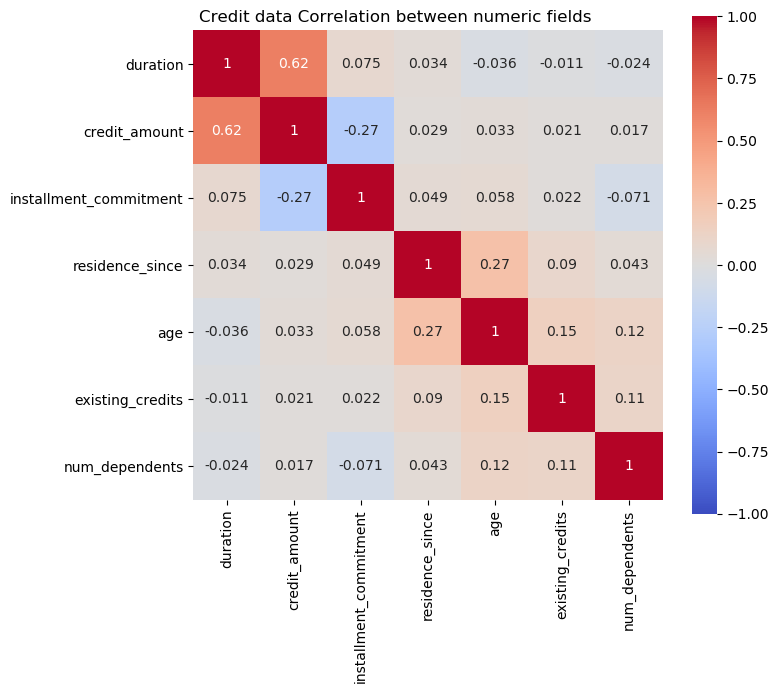

In [5]:
    correlation = df.corr()
    pd.options.display.width = 180
    pd.options.display.max_rows = 7
    pd.options.display.max_columns = 7
    print('display.max_columns:', pd.options.display.max_columns)
    print(correlation)

    plt.figure(figsize=(8, 7))
    plt.suptitle('Credit data Correlation between numeric fields')
    sns.heatmap(correlation, annot=True, square=True, vmin=-1.0, vmax=1.0, cmap='coolwarm')
    plt.tight_layout()
    plt.show()


### Scatter matrix

Plotting a scatter matrix shows that there are no trivial decision boundaries.

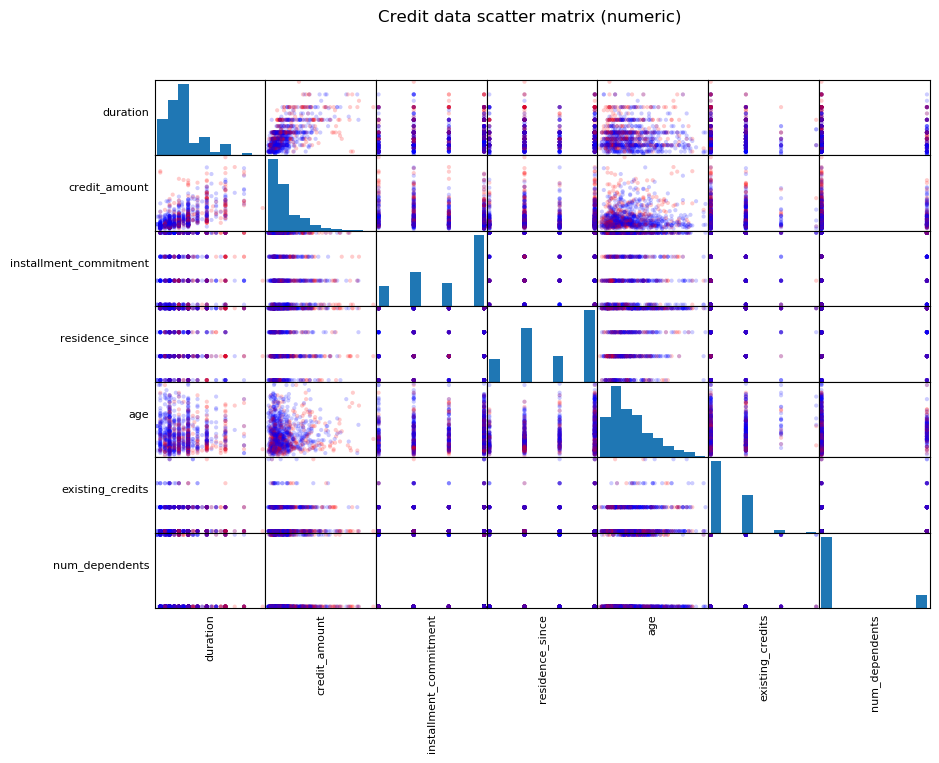

In [6]:
    # Scatter plot showing the data colour coded by class
    # Colour Labels - bad in red and good in blue
    label_colors = {'bad': 'red', 'good': 'blue'}
    label_colors_list = list(map(lambda x: label_colors.get(x), list(df['class'])))
    # Plotting the scatter matrix
    axes = pd.plotting.scatter_matrix(df, c=label_colors_list, alpha=0.2, figsize=(10, 7))
    for ax in axes.flatten():
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.xaxis.label.set_fontsize(8)
        ax.yaxis.label.set_fontsize(8)
        ax.xaxis.label.set_rotation(90)
        ax.yaxis.label.set_rotation(0)
        ax.yaxis.label.set_ha('right')
    plt.suptitle("Credit data scatter matrix (numeric)")
    plt.gcf().subplots_adjust(wspace=0, hspace=0)
    plt.show()


### Scikit-learn

Generally, Scikit-learn works on any numeric data stored as numpy arrays or scipy sparse matrices.
Other types that are convertible to numeric arrays such as pandas DataFrame are also acceptable.
Categorical (or nominal) features stored as strings will need converting to numerical features using OneHotEncoder or OrdinalEncoder or similar. The target label must be numeric.

Data is converted in the preprocess_data function.

Also, the data is split into a training set and a hold out test data set, so that the models can be tested on unseen data.

In [7]:
    # Prepare the data for Scikit-learn    
    x, y, features, classes = preprocess_data()

    # Train / Test split stratified by good or bad loan label
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=42)


dataset_31_credit-g.csv
Input data shape: (1000, 21)


### Principal Component Analysis


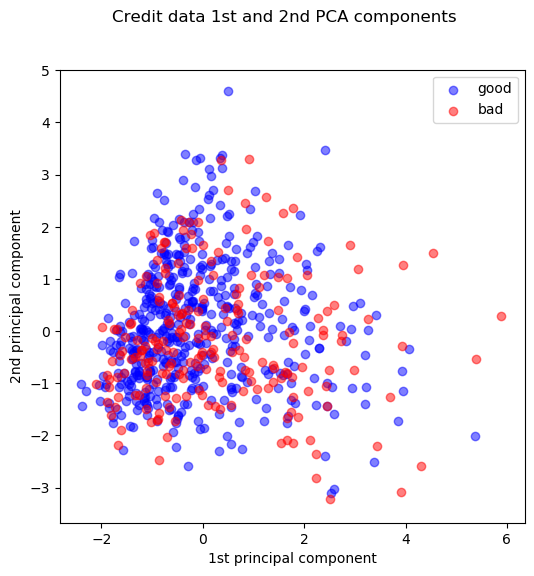

In [10]:
    # Apply Principal Component Analysis to extract the first 2 principal components

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)

    scale_transformer = make_scale_transformer()
    x_scaled = scale_transformer.fit_transform(x_train)

    #  Strange sklearn bug where it throws an exception but works the second time ????
    try:
        pca.fit(x_scaled)
    except ValueError:
        pca.fit(x_scaled)

    # Plot the training data after PCA
    x_train_pca = pca.transform(x_scaled)
    plt.figure(figsize=(6, 6))
    plt.suptitle("Credit data 1st and 2nd PCA components")
    plt.scatter(x_train_pca[y_train == 0, 0],
                x_train_pca[y_train == 0, 1],
                color='blue', alpha=0.5,
                label='good')
    plt.scatter(x_train_pca[y_train == 1, 0],
                x_train_pca[y_train == 1, 1],
                color='red', alpha=0.5,
                label='bad')
    plt.xlabel('1st principal component')
    plt.ylabel('2nd principal component')
    plt.legend()
    plt.show()


### Now train a Decision Tree Model (CART)

### Initial Decision Tree classifier

An initial random forest classifier is trained and applied to the hold-out test set. The confusion matrix is displayed for both training and test data.

Decision tree: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}
Training confusion matrix
[[490   0]
 [  0 210]]
              precision    recall  f1-score   support

        good       1.00      1.00      1.00       490
         bad       1.00      1.00      1.00       210

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700

Test confusion matrix
[[165  45]
 [ 37  53]]
              precision    recall  f1-score   support

        good       0.82      0.79      0.80       210
         bad       0.54      0.59      0.56        90

    accuracy                           0.73       300
   macro

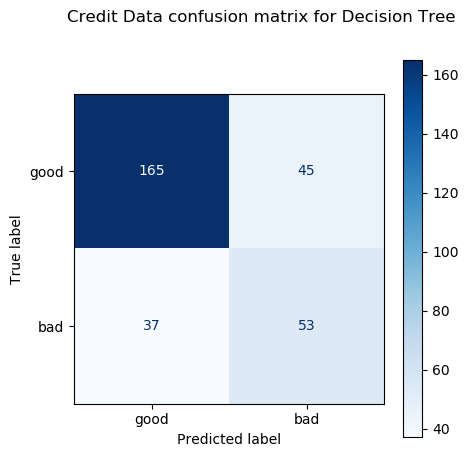

In [13]:
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.tree import plot_tree
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import roc_curve, plot_roc_curve

    # Decision Tree
    # decision_tree = DecisionTreeClassifier(class_weight={0:1/6.0, 1:5/6.0})  # , max_depth=7)
    # weights = n_samples / (n_classes * np.bincount(y))
    weights = y_train.size / (2.0 * np.bincount(y_train))
    decision_tree = DecisionTreeClassifier(class_weight='balanced')
    print('Decision tree:', decision_tree.get_params())
    decision_tree.fit(x_train, y_train)
    y_train_pred = decision_tree.predict(x_train)
    cm_train = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
    print('Training confusion matrix')
    print(cm_train)
    cr_train = classification_report(y_train, y_train_pred, labels=range(len(classes)), target_names=classes)
    print(cr_train)

    y_test_pred = decision_tree.predict(x_test)
    cm_test = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    print('Test confusion matrix')
    print(cm_test)
    cr_test = classification_report(y_test, y_test_pred, labels=range(len(classes)), target_names=classes)
    print(cr_test)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    cm_display = ConfusionMatrixDisplay(cm_test, display_labels=classes)
    cm_display.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
    plt.suptitle('Credit Data confusion matrix for Decision Tree')
    plt.show()


### Hyper-parameters

The Decision Tree performs perfectly on the training data but performs poorly on the test data, so is likely overfitting.

The complexity of the tree can be limited by setting hyper-parameters such as the max_depth. Search for a good combination of hyper-parameters using a grid search and the area under the ROC curve as the metric.

In [15]:
    # Decision Tree is scoring 100% on the training data so it may be over fitting.
    # Use K-fold cross validation to determine the hyper-parameters.
    from sklearn.model_selection import GridSearchCV

    params = [{'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
               'max_features': [None, 'auto', 5, 10, 20]}]
    # Don't need to shuffle the K folds as train_test_split already shuffled the data
    grid = GridSearchCV(DecisionTreeClassifier(class_weight='balanced', random_state=21, min_samples_leaf=5),
                        params, cv=5, scoring='roc_auc')
    # scoring='accuracy' 'neg_log_loss' 'recall')
    grid.fit(x_train, y_train)

    print("Best score:", grid.best_score_, "Best params:", grid.best_params_)
    # Use best_estimator_ refitted using all the training data
    decision_tree = grid.best_estimator_
    print('Decision tree:', decision_tree.get_params())


Best score: 0.7355442176870748 Best params: {'max_depth': 6, 'max_features': 20}
Decision tree: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 20, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 21, 'splitter': 'best'}


### Feature importance

The features are ranked in importance and displayed.

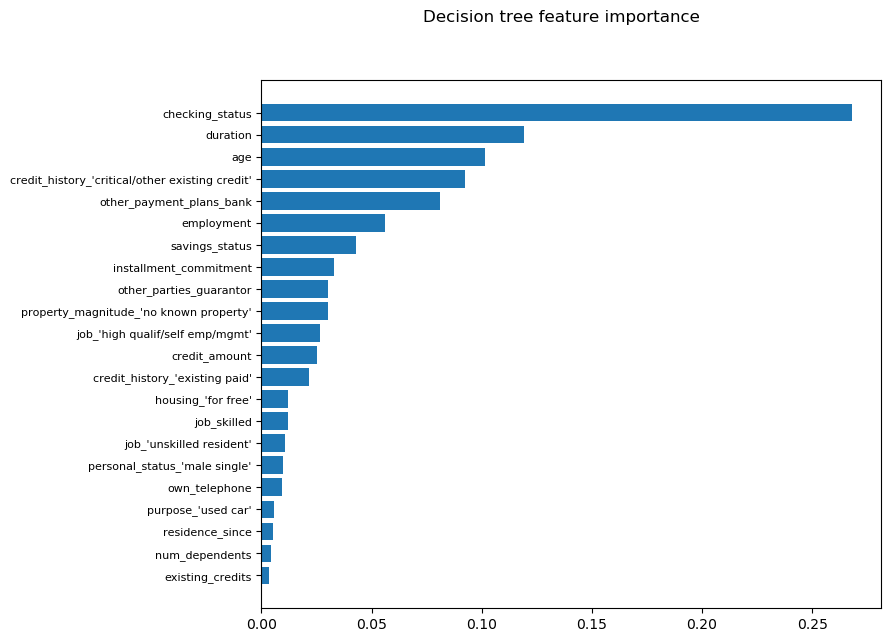

In [17]:
    feature_indexes = np.argsort(decision_tree.feature_importances_)[::-1]
    num_features = len(decision_tree.feature_importances_[decision_tree.feature_importances_ > 0.0])
    feature_name_array = np.array(features)
    plt.figure(figsize=(8, 7))
    plt.suptitle("Decision tree feature importance")
    plt.barh(range(num_features), decision_tree.feature_importances_[feature_indexes][:num_features])
    plt.yticks(range(num_features), feature_name_array[feature_indexes][:num_features], fontsize=8)
    plt.gca().invert_yaxis()
    plt.show()


### ROC Curve

The ROC curve can be used to select a probability threshold for classifying a loan as positive (bad).

The default threshold is 0.5 when using the predict function.

The threshold is selected using the ROC curve for the training data.


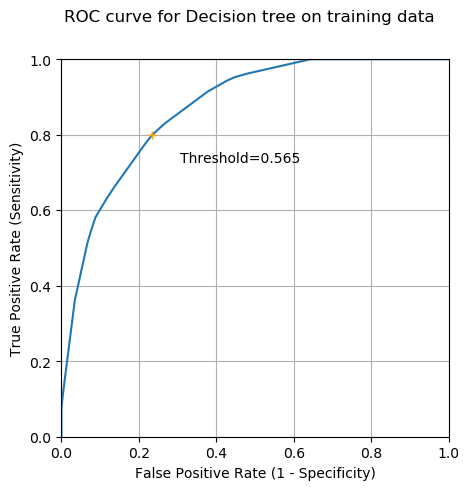

In [21]:
    # ROC Curve
    y_probs = decision_tree.predict_proba(x_train)[:, 1]
    fprs, tprs, thresholds = roc_curve(y_train, y_probs)
    plt.figure(figsize=(5, 5))
    plt.suptitle('ROC curve for Decision tree on training data')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid(True)
    plt.plot(fprs, tprs)
    # Plot the threshold closest to the default of 0.5
    t = thresholds[thresholds >= 0.5][-1]
    tpr = tprs[thresholds >= 0.5][-1]
    fpr = fprs[thresholds >= 0.5][-1]
    plt.plot(fpr, tpr, '+', color='orange')
    plt.annotate('Threshold={:5.3f}'.format(t), xy=(fpr, tpr), xytext=(20, -20), textcoords='offset points')
    plt.show()


In [29]:
    # Test the model on the unseen Test set using the default threshold of 0.5
    y_test_pred = decision_tree.predict(x_test)
    cm_test = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    print('Test confusion matrix')
    print(cm_test)
    cr_test = classification_report(y_test, y_test_pred, labels=range(len(classes)), target_names=classes)
    print(cr_test)
    
    # Banks want to identify customers who are likely to default on a loan.
    # The recall for predicting bad loans is only around 63%.


Test confusion matrix
[[146  64]
 [ 33  57]]
              precision    recall  f1-score   support

        good       0.82      0.70      0.75       210
         bad       0.47      0.63      0.54        90

    accuracy                           0.68       300
   macro avg       0.64      0.66      0.65       300
weighted avg       0.71      0.68      0.69       300



### Visualise the Decision Tree to a depth of 3

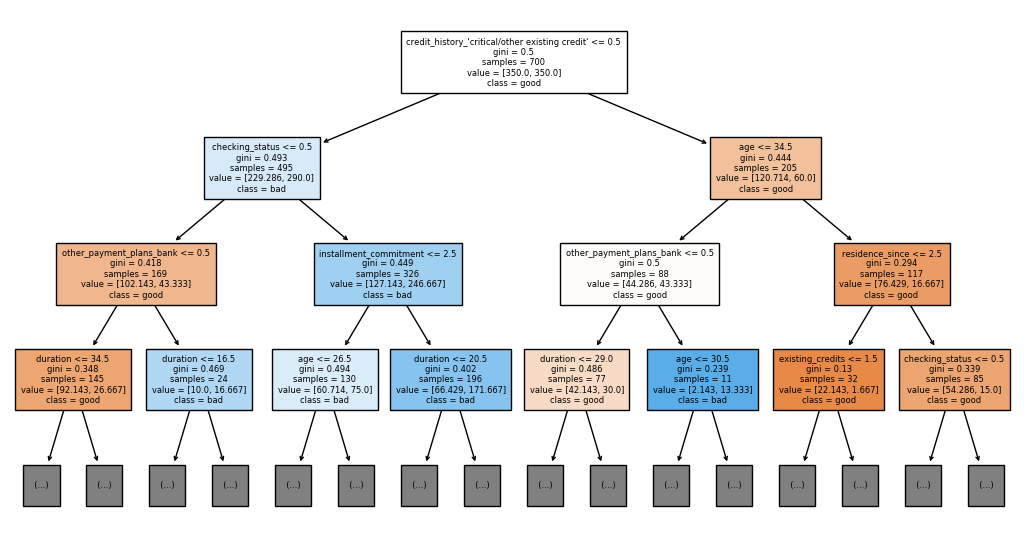

In [24]:
    plt.figure(figsize=(13, 7))
    plot_tree(decision_tree, filled=True, feature_names=features, class_names=classes, fontsize=6, max_depth=3)
    plt.show()